Saved: cluster_assignments.csv


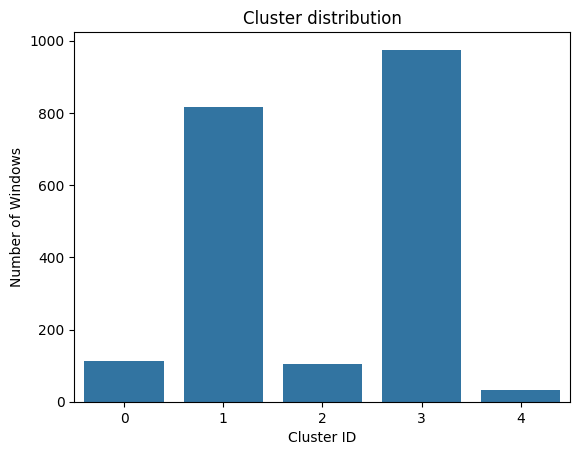

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- Config ---
WINDOW_SIZE = 10         # Number of timesteps per slice
STEP_SIZE = 1            # Slide the window forward by 1 each time
N_CLUSTERS = 5           # Number of clusters for KMeans
CSV_PATH = "state_action_dataset.csv"  # Change if your path is different

# --- Load dataset ---
df = pd.read_csv(CSV_PATH)

# Select only the state columns for clustering
state_cols = [col for col in df.columns if col.startswith('state_')]
states = df[state_cols].values

# --- Create rolling window slices ---
windows = []
start_indices = []

for i in range(0, len(states) - WINDOW_SIZE + 1, STEP_SIZE):
    window = states[i:i+WINDOW_SIZE].flatten()  # Flatten to a single vector
    windows.append(window)
    start_indices.append(i)

X = np.array(windows)  # Shape: (num_windows, window_size * num_features)

# --- Run KMeans clustering ---
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
labels = kmeans.fit_predict(X)

# --- Save the result ---
results_df = pd.DataFrame({
    "start_index": start_indices,
    "cluster": labels
})
results_df.to_csv("cluster_assignments.csv", index=False)
print("Saved: cluster_assignments.csv")

# --- Optional: Visualize cluster counts ---
sns.countplot(x=labels)
plt.title("Cluster distribution")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Windows")
plt.show()


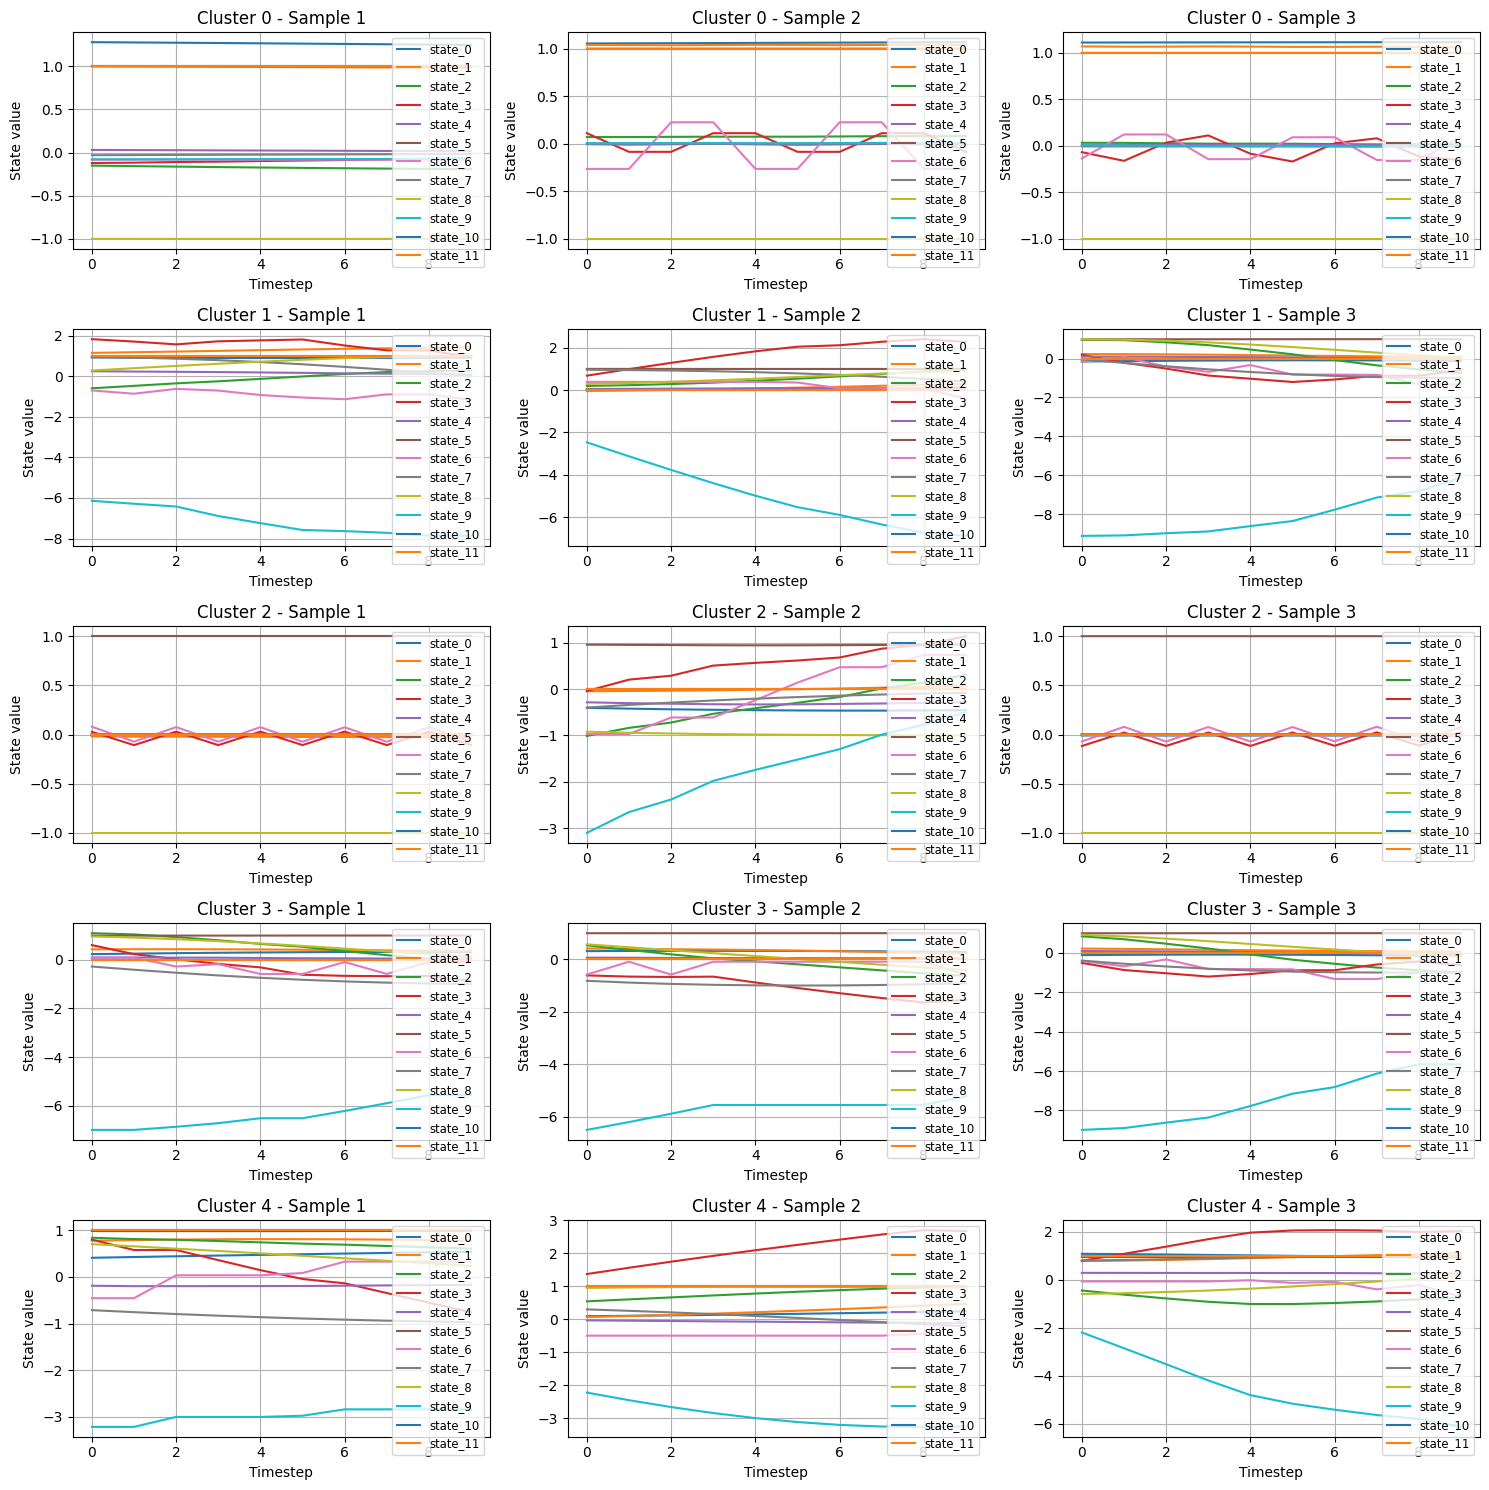

In [5]:
import random

# Run KMeans clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
cluster_labels = kmeans.fit_predict(windows)


# Create DataFrame with cluster labels and corresponding windows
clustered_df = pd.DataFrame({
    "start_index": start_indices,
    "cluster": cluster_labels,
    "window": windows
})

# Pick a few sample windows from each cluster
SAMPLES_PER_CLUSTER = 3
STATE_DIM = int(len(windows[0]) / WINDOW_SIZE)

fig, axs = plt.subplots(N_CLUSTERS, SAMPLES_PER_CLUSTER, figsize=(15, 3 * N_CLUSTERS), squeeze=False)

for cluster_id in range(N_CLUSTERS):
    samples = clustered_df[clustered_df["cluster"] == cluster_id].sample(min(SAMPLES_PER_CLUSTER, len(clustered_df[clustered_df["cluster"] == cluster_id])), random_state=42)

    for j, (_, row) in enumerate(samples.iterrows()):
        window_flat = row["window"]
        window_matrix = np.array(window_flat).reshape(WINDOW_SIZE, STATE_DIM)

        for state_idx in range(STATE_DIM):
            axs[cluster_id, j].plot(window_matrix[:, state_idx], label=f'state_{state_idx}')
        
        axs[cluster_id, j].set_title(f'Cluster {cluster_id} - Sample {j+1}')
        axs[cluster_id, j].set_xlabel("Timestep")
        axs[cluster_id, j].set_ylabel("State value")
        axs[cluster_id, j].grid(True)
        axs[cluster_id, j].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Load dataset
df = pd.read_csv("state_action_dataset.csv")

# Extract relevant columns
state_action_columns = [col for col in df.columns if col.startswith("state_") or col.startswith("action_")]
data = df[state_action_columns].values

# Parameters
WINDOW_SIZE = 10
STEP_SIZE = 1
N_CLUSTERS = 5

# Create sliding windows
windows, start_indices = [], []
for i in range(0, len(data) - WINDOW_SIZE + 1, STEP_SIZE):
    window = data[i:i + WINDOW_SIZE].flatten()
    windows.append(window)
    start_indices.append(i)

# Run KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(windows)

# Build export dataframe
rows = []
for idx, (start, flat, cluster) in enumerate(zip(start_indices, windows, cluster_labels)):
    rows.append({
        "window_index": idx,
        "timestep_range": f"{start}-{start + WINDOW_SIZE - 1}",
        "flattened_window": flat.tolist(),
        "cluster_id": cluster
    })

export_df = pd.DataFrame(rows)
export_df.to_csv("window_cluster_mapping.csv", index=False)


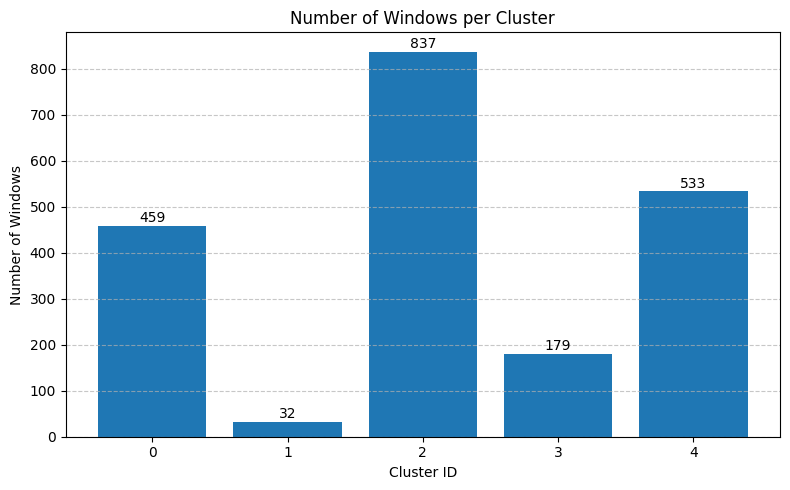

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("window_cluster_mapping.csv")

# Count how many windows per cluster
cluster_counts = df['cluster_id'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Windows")
plt.title("Number of Windows per Cluster")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import ast

df = pd.read_csv("window_cluster_mapping.csv")
sample = ast.literal_eval(df.iloc[0]["flattened_window"])
print(f"Length of flattened window: {len(sample)}")


Length of flattened window: 140


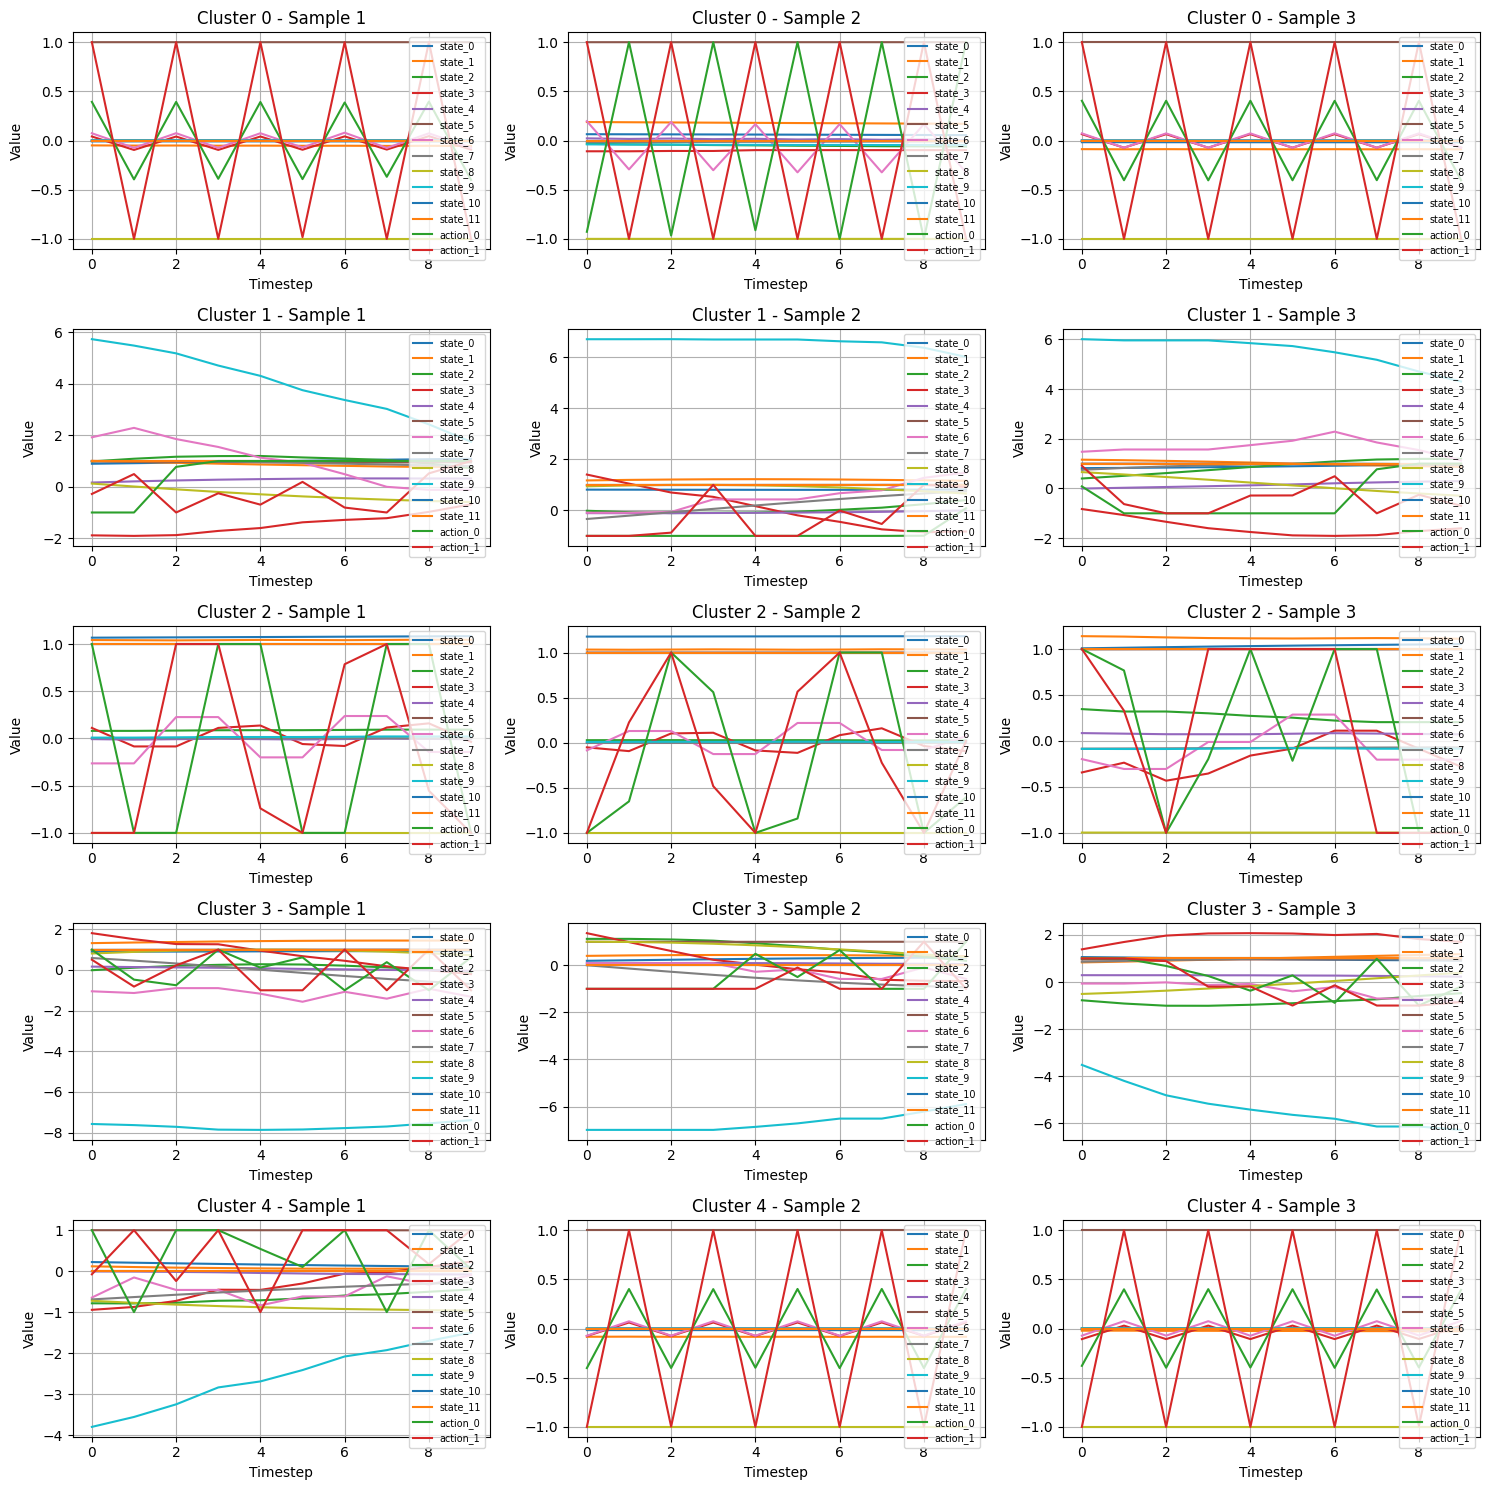

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

# Load clustered window CSV
df = pd.read_csv("window_cluster_mapping.csv")

# Constants
WINDOW_SIZE = 10
NUM_FEATURES = 14  # 12 states + 2 actions
SAMPLES_PER_CLUSTER = 3

# Generate feature names
state_names = [f"state_{i}" for i in range(12)]
action_names = [f"action_{i}" for i in range(2)]
feature_names = state_names + action_names

# Prepare plot
n_clusters = df['cluster_id'].nunique()
fig, axs = plt.subplots(n_clusters, SAMPLES_PER_CLUSTER, figsize=(15, 3 * n_clusters), squeeze=False)

for cluster_id in range(n_clusters):
    cluster_rows = df[df["cluster_id"] == cluster_id]
    sampled_rows = cluster_rows.sample(n=SAMPLES_PER_CLUSTER, random_state=42)

    for j, (_, row) in enumerate(sampled_rows.iterrows()):
        # Convert string to array and reshape
        flat = np.array(ast.literal_eval(row["flattened_window"]))
        window_matrix = flat.reshape(WINDOW_SIZE, NUM_FEATURES)

        ax = axs[cluster_id, j]
        for feature_idx in range(NUM_FEATURES):
            ax.plot(window_matrix[:, feature_idx], label=feature_names[feature_idx])

        ax.set_title(f"Cluster {cluster_id} - Sample {j+1}")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend(loc='upper right', fontsize='x-small')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import random

# Load the clustered dataset
df = pd.read_csv("window_cluster_mapping.csv")

# Configurations
WINDOW_SIZE = 10
NUM_SAMPLES_PER_CLUSTER = 3

# Define feature indices to keep (adjust these based on your knowledge of feature mapping)
# For example: state_0, state_6, state_9, action_0, action_1
SELECTED_FEATURE_INDICES = [0, 6, 9, 12, 13]

# Map indices to names (optional, for better legend)
feature_names = {
    0: "state_0",
    6: "state_6",
    9: "state_9",
    12: "action_0",
    13: "action_1"
}

# Determine number of features per timestep
flat_sample = ast.literal_eval(df['flattened_window'].iloc[0])
NUM_FEATURES = len(flat_sample) // WINDOW_SIZE

# Get unique clusters
cluster_ids = sorted(df['cluster_id'].unique())
N_CLUSTERS = len(cluster_ids)

# Create plot
fig, axs = plt.subplots(N_CLUSTERS, NUM_SAMPLES_PER_CLUSTER, figsize=(5 * NUM_SAMPLES_PER_CLUSTER, 4 * N_CLUSTERS), squeeze=False)

for i, cluster_id in enumerate(cluster_ids):
    cluster_rows = df[df['cluster_id'] == cluster_id]

    # Randomly sample rows from this cluster
    sampled_rows = cluster_rows.sample(n=min(NUM_SAMPLES_PER_CLUSTER, len(cluster_rows)), random_state=42)

    for j, (_, row) in enumerate(sampled_rows.iterrows()):
        flat = np.array(ast.literal_eval(row["flattened_window"]))
        window_matrix = flat.reshape(WINDOW_SIZE, NUM_FEATURES)

        ax = axs[i][j]
        for idx in SELECTED_FEATURE_INDICES:
            ax.plot(range(WINDOW_SIZE), window_matrix[:, idx], label=feature_names[idx])

        ax.set_title(f"Cluster {cluster_id} - Sample {j+1}")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()
